<a href="https://colab.research.google.com/github/GabrielCostaDeOliveira/faceDetectionTraining/blob/main/faceDetectionDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from fastai.vision.all import *
import numpy as np

Definindo o `path` para o dataset.

In [2]:
path = Path(os.path.join(os.getcwd(), '..', 'dataset'))
Path.BASE_PATH = path
path.ls()

(#3) [Path('wider_face_split'),Path('WIDER_train'),Path('WIDER_val')]

Verificando se as imagens não foram corrompidas

In [3]:
images = get_image_files(path)
failed = verify_images(images)
failed

(#0) []

Eliminando as imagens que falharam

In [4]:
failed.map(Path.unlink)

(#0) []

Definindo funções auxiliares para recuperar as anotações das imagens dado seu _path_

In [5]:
def img2bbox_path(path: Path):
    return 'annotations'.join(str(path).rsplit('images', 1))[:-4]

def get_annotation_values(path: Path):
    with open(img2bbox_path(path), 'r', encoding='utf-8') as f:
        return np.array([[*map(int, s.split())] for s in f.readlines()])

Função para recuperar a bounding box de uma imagem dado seu caminho

In [6]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return ctr[:,:4]
    return []

Visualizando um exemplo de imagem com sua bounding box

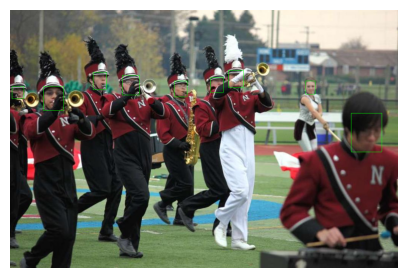

In [7]:
img = plt.imread(images[0]).copy()
for x,y,w,h in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y,x:x+w] = color
    img[y:y+h,x] = color
    img[y+h,x:x+w] = color
    img[y:y+h,x+w] = color
show_image(img);

A fastai espera a bounding box no formato [`left`, `top`, `right`, `bottom`].

Porém o nosso dataset utiliza no formato [`left`, `top`, `width`, `height`].

Então precisamos converter a bounding box para o formato da fastai. Para isso vamos alterar a função `get_bbox` definida anteriormente.

In [8]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [[x, y, x + w, y + h] for x, y, w, h in ctr[:,:4]]
    return []

apresentando a mesma imagem com o novo formato da bounding box

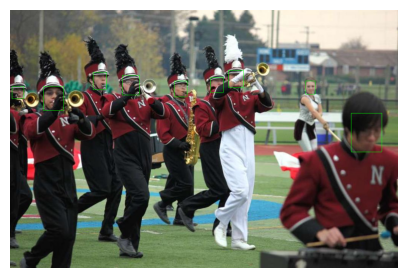

In [9]:
img = plt.imread(images[0]).copy()
for x1,y1,x2,y2 in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y1,x1:x2] = color
    img[y1:y2,x1] = color
    img[y2,x1:x2] = color
    img[y1:y2,x2] = color
show_image(img);

Função para recuperar os labels de uma imagem dado seu _path_

In [10]:
def get_label(path, lbl=['no occlusion', 'partial occlusion', 'heavy occlusion']):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [lbl[x] for x in ctr[:,-2]]
    return []

In [11]:
data_block = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    get_items=get_image_files,
    getters=[noop, get_bbox, get_label],
    splitter=FuncSplitter(lambda o: o.parent.parent.parent.name.endswith('val')),
    item_tfms=Resize(256),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    n_inp=1
)
data_block.summary(path)

Setting-up type transforms pipelines
Found 16106 items
2 datasets of sizes 12880,3226
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_bbox -> TensorBBox.create
Setting up Pipeline: get_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}

Building one sample
  Pipeline: PILBase.create
    starting from
      c:\Users\Thalisson\prog\aulas\ml\faceDetectionTraining\src\..\dataset\WIDER_train\images\0--Parade\0_Parade_marchingband_1_100.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1024x682
  Pipeline: get_bbox -> TensorBBox.create
    starting from
      c:\Users\Thalisson\prog\aulas\ml\faceDetectionTraining\src\..\dataset\WIDER_train\images\0--Parade\0_Parade_marchingband_1_100.jpg
    applying get_bbox gives
      [[433, 189, 467, 231], [88, 203, 141, 267], [5, 203, 36, 236], [296, 174, 341, 226], [219, 166, 254, 212], [900, 274, 981, 376], [780, 189, 805, 224], [576, 161, 616, 206], [529, 180, 563, 220]]
    applying TensorBBox.cre

Como podemos ver, nosso dataset é possui `12880` itens para treino e `3226` para validação.

In [12]:
datasets = data_block.datasets(path)

len(datasets.train), len(datasets.valid)

(12880, 3226)

Onde cada item é composto por uma imagem (a variável independente), uma tensor de bounding boxes e um tensor de multi categorias (que juntos compõem as variáveis dependentes).

In [13]:
datasets.train[0]

(PILImage mode=RGB size=1024x682,
 TensorBBox([[433., 189., 467., 231.],
             [ 88., 203., 141., 267.],
             [  5., 203.,  36., 236.],
             [296., 174., 341., 226.],
             [219., 166., 254., 212.],
             [900., 274., 981., 376.],
             [780., 189., 805., 224.],
             [576., 161., 616., 206.],
             [529., 180., 563., 220.]]),
 TensorMultiCategory([2, 1, 3, 1, 2, 2, 2, 1, 1]))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


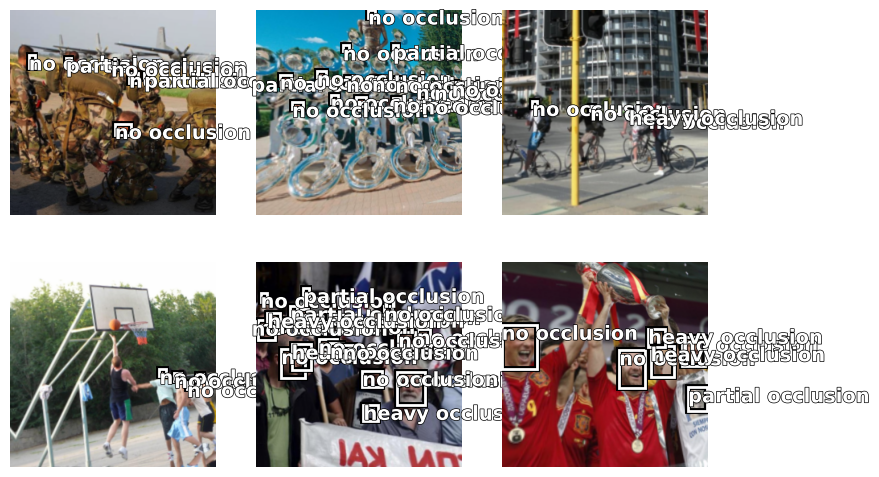

In [14]:
data_loaders = data_block.dataloaders(path)
data_loaders.train.show_batch(max_n=6)